# Problem Definition
## Business & ML Success Metrics
	•	Business goal
	•	Constraints (latency, cost, explainability)
	•	Offline metric vs online metric
	•	Failure tolerance

**Business Goal:**  
Reduce customer churn by accurately identifying customers at risk of leaving, enabling targeted retention strategies.

**Constraints:**  
- **Latency:** Predictions must be available within operational timelines (e.g., daily batch or near real-time).
- **Cost:** Solution should balance predictive performance with infrastructure and maintenance costs.
- **Explainability:** Models must provide interpretable outputs to support business decisions and regulatory requirements.

**Offline Metric vs Online Metric:**  
- **Offline:** Evaluate model performance using metrics such as accuracy, precision, recall, F1-score, and AUC on historical data.
- **Online:** Monitor real-world impact through retention rates, incremental revenue, and customer engagement post-deployment.

**Failure Tolerance:**  
Define acceptable thresholds for false positives/negatives and establish fallback mechanisms to minimize business risk in case of model or data issues.

In [7]:
!pip install -q pandas numpy matplotlib

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Sources
## Data Contracts & Assumptions

	•	Upstream systems
	•	Schema expectations
	•	Freshness guarantees
	•	Null/enum constraints

# Read Data

In [9]:
df = pd.read_csv("./data/raw_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data Quality Checks

	•	Schema validation
	•	Range checks
	•	Missing value profiling
	•	Duplicate detection

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Text(0.5, 0.98, '')

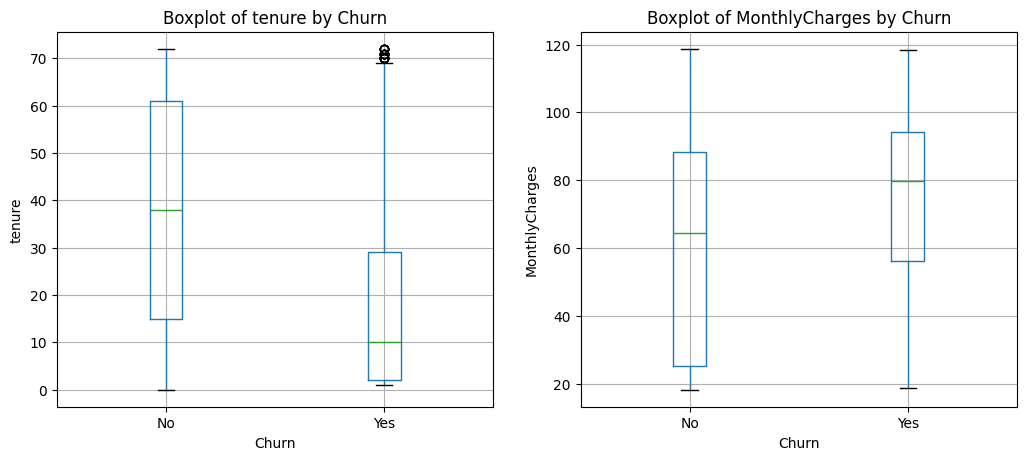

In [12]:
num_cols = ['tenure', 'MonthlyCharges']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot numerical columns vs Churn
for i, col in enumerate(num_cols):
    df.boxplot(column=col, by='Churn', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)
plt.suptitle('')


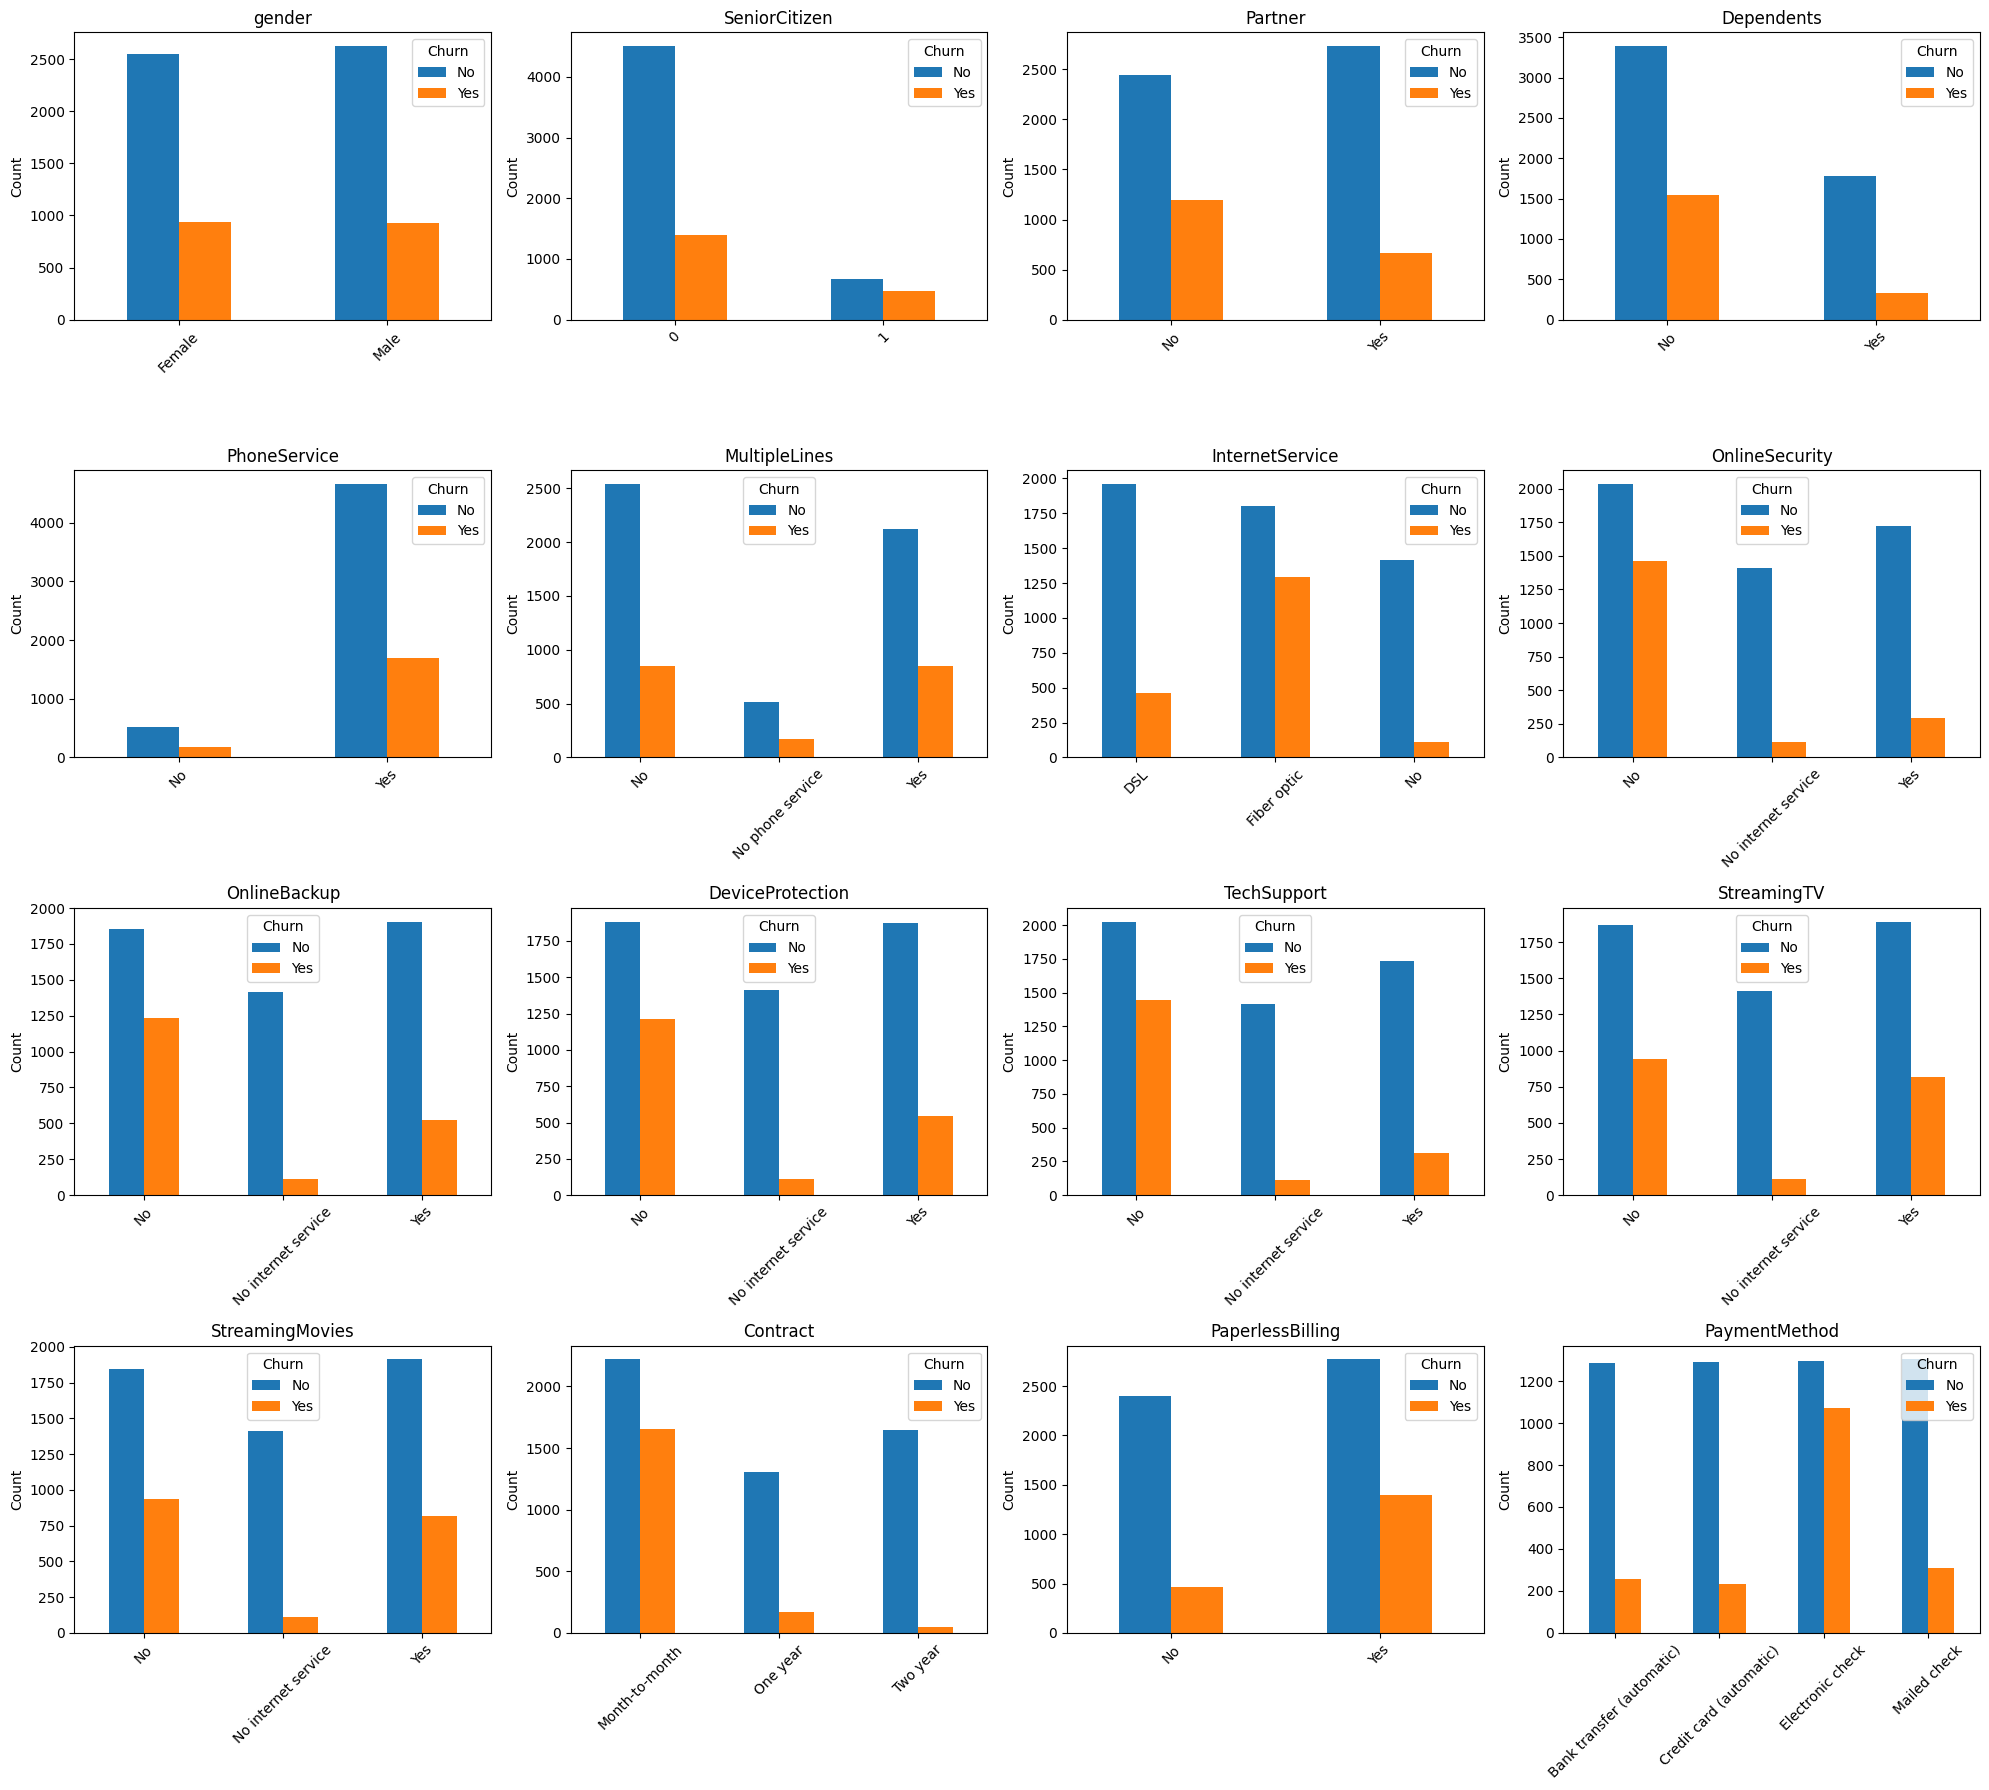

In [13]:
cat_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

fig, axes = plt.subplots(
    nrows=4, ncols=4, figsize=(20, 18)
)

axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ct = pd.crosstab(df[col], df["Churn"])
    ct.plot(kind="bar", ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=45)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Non-ML Base Line:

	•	Rule-based / heuristic
	•	Historical average
	•	Majority class

Label: Churn = Yes/No
If customer renew then Churn = No
If customer does not renew then Churn = Yes

From the columns, the high signal columns (guess by name/description or asked the data collection team) are
- tenure (signal: high,  <= 10)
- MonthLyCharges (signal: low,  >= 80)
- Contract (signal: high, 'Month-to-month')
- PaymentMethod (signal: low, 'Electronic check')
- OnlineSecurity (signal: low, 'No')
- TechSupport (signal: low, 'No')

Hence a Base Could for Churn could be
(I will use a scoring base on how strong is the signal based on the data)

```
Score = 0
+2 if tenure <= 10
+2 if Contract == Month-to-month
+1 if MonthlyCharges >= 80
+1 if PaymentMethod == Electronic check
+1 if OnlineSecurity == No
+1 if TechSupport == No

Churn = Yes if Score >= 4 Else No
```


I expect this to give me high precision and moderate recall (confident, not exhaustive) performance

# Feature Engineering
	•	Feature definitions
	•	Aggregations
	•	Leakage checks
	•	Feature versioning

# Data Splitting Strategy
	•	Time-based split (preferred)
	•	Cross-validation logic
	•	Why this split mirrors production

# Baseline ML Models
	•	Simple, interpretable models
	•	Compare vs non-ML baseline

# Advanced Models
	•	Ensembles / deep models
	•	Justification for complexity


# Model Evaluation
## Robustness Checks

	•	Standard metrics
	•	Slice analysis
	•	Stress tests
	•	Noise injection
    

# Model Interpretability
	•	Global importance
	•	Local explanations
	•	Sanity checks

# Final Model Selection
	•	Performance vs cost
	•	Stability
	•	Explainability

# Model Packaging
	•	Model artifacts
	•	Feature code
	•	Environment (conda / docker)
	•	Versioning

# Deployment Architecture
	•	Batch vs real-time
	•	Model serving path
	•	Feature availability
	•	Latency budget


# Monitoring Strategy
## Data Drift Monitoring
	•	Input feature distribution shift
	•	PSI / KS / Wasserstein
	•	Reference window

## Prediction Drift
	•	Output distribution shift
	•	Confidence collapse


## Concept Drift
	•	Performance decay
	•	Delayed labels
	•	Retraining triggers

## Signal Loss Detection
	•	Feature missing rate spikes
	•	Zero / constant features
	•	Cardinality collapse
	•	Late-arriving data

# Alerts & Thresholds
	•	Warning vs critical
	•	Who gets paged
	•	Auto-disable model logic

# Fallback Strategy
	•	Switch to non-ML baseline
	•	Last known good model
	•	Partial feature mode

# Retraining & Automation Strategy
	•	Scheduled vs trigger-based
	•	Drift-based retraining
	•	Human-in-the-loop

# Model Governance
	•	Model registry
	•	Audit trail
	•	Approval workflow


# Post-Deployment Validation
	•	Shadow mode
	•	Canary deployment
	•	A/B testing


# Failure Modes & Risk Register
	•	Data outages
	•	Upstream schema changes
	•	Adversarial inputs
	•	Model staleness

# Conclusions & Next Steps
	•	Remaining risks
	•	Scalability plan
	•	Future improvements

## Remaining Risks
	•	Delayed or noisy labels limit fast performance validation
	•	Subtle concept drift not detected by simple drift metrics
	•	Partial upstream signal degradation or schema changes
	•	Monitoring and alerting latency before rollback

## Scalability Plan
	•	Scale data processing via partitioned or distributed pipelines
	•	Autoscale model serving and separate batch vs real-time inference
	•	Sample-based monitoring and segmented metrics
	•	Support multiple model versions via registry and CI/CD

## Future Improvements
	•	Add stronger predictive signals and freshness tracking
	•	Improve uncertainty estimation and calibration
	•	Automate drift-triggered retraining and fallback
	•	Use online evaluation (A/B tests, shadow deployment)
